# Classification of pitches

The goal here is to classify the types of pitches thrown by a given pitcher. Though the pitchfx data comes with pitch classfications, it is known to not be very reliable ("It is accurate enough for most work that involves differentiating between fastballs and off-speed pitches"--Fast, "What the heck is PitchFX?"). Additionally, clustering is a logical task to perform with PitchFX and has a good chance to be able to separate pitches.

To start, I will link the relevant libraries.

In [1]:
# imports
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import subprocess
%matplotlib inline

## Gathering data

For pitch classification, I will choose one pitcher to examine. I'll choose 'Barry Zito', who I investigated briefly in EDA. He is known for the break of his curveball and a below-average fastball.

### Connecting to database

First specify the database name and path, then connect to the database.

In [2]:
# specify database name
dbname = "../dat/pitchfx2008.db"

# connect to the sqlite3 database
db = sqlite3.connect(dbname)
hdb = db.cursor()

### Selecting pitches

I'll query the database to get all the pitches he threw in 2008.  Note that I will not worry about sorting the pitches by pitch number since I am just clustering pitches. Additionally, the *pitchfx* table does not have the pitcher id stored. Instead, I have to link the *pitchfx* table to the *events* table to get player id information. I'll print out the first five pitches.

In [3]:
query = """SELECT DISTINCT pitchfx.* 
    FROM pitchfx
    JOIN events ON (pitchfx.game_id=events.game_id
        AND pitchfx.cur_event=events.event_id)
    WHERE events.pitcher_id=(SELECT player_id
        FROM players
        WHERE players.player_first='Barry'
            AND players.player_last='Zito')
    ORDER BY game_id, pitch_num"""
bz_pfx = pd.read_sql_query(query, db)
bz_pfx.head()

game_id  pitch_num  at_bat      time  cur_event      description outcome  \
0   233769         30       4  134206.0          7             Ball       B   
1   233769         31       4  134217.0          7    Called Strike       S   
2   233769         32       4  134228.0          7             Foul       S   
3   233769         33       4  134247.0          7  In play, no out       X   
4   233769         37       5  134336.0          8             Ball       B   

   pre_balls  post_balls  pre_strike     ...        vz0     ax      ay  \
0          0           1           0     ...     -4.167 -4.395  28.973   
1          1           1           0     ...     -7.852 -1.776  29.654   
2          1           1           1     ...     -2.479  3.593  22.606   
3          1           1           2     ...     -5.803 -1.431  30.550   
4          0           1           0     ...     -2.421 -3.625  31.828   

       az  break_y  break_angle  break_length  spin_dir  spin_rate  pitch_type  
0 -13.125     23.7         16.5           3.9   192.990   2278.601          FC  
1  -9.818     23.7          8.9           3.2   184.540   2620.543          FF  
2 -23.886     23.7         -8.3           9.2   156.564   1243.876          CH  
3  -8.798     23.7         12.1           2.8   183.501   2732.740          FF  
4 -12.756     23.6         18.5           3.8   190.573   2300.700          FF  

[5 rows x 36 columns]

## Data cleaning and feature selection

The goal here is to classify pitches myself, as EDA revealed some apparent pitch misclassifications (for instance, some cutters seemed to be grouped with sliders when looking at movement information).

From EDA I saw that the pitch data for Barry Zito contains a number of Nans. Fortunately, the Nans appeared to be spread out throughout data observations (such they appear somewhat random over time and are unlikely to add any bias), and they were only present in 3% of the pitches. I could choose to impute some of the missing values for a given observation, but from EDA I saw that where there were Nans for a given pitch, nearly all of the columns related to trajectory were missing. Therefore, I'll drop the pitches containing any Nans rather than try to fill them in based on only situational information.

In [4]:
# number of data points before
print("number of observations including nans: ", bz_pfx.shape[0])

# drop nans
bz_pfx = bz_pfx.dropna(axis=0, how="any")

# number of data points after
print("number of observations without nans: ", bz_pfx.shape[0])

number of observations including nans:  3206
number of observations without nans:  3102


From PCA, I saw that the first principal component (which explained 30% of the total variance in the data) was primarily a measure of pitch trajectory, while the subsequent components were measures of pitch location and situtational information (which explained less than 15% of the variance in the data each). Since the goal here is pitch classification, I will keep only columns related to trajectory information tied to the first principal component for clustering. Note that I will keep `pitch_type` for now, as it contains the pitch classifications from the database that I can compare results to.

Decriptions of these pitch variables can be found here: https://fastballs.wordpress.com/category/pitchfx-glossary. I'll also drop pitches that are classified as intentional balls ("IN") and pitch outs ("PO").

In [5]:
# drop pitches that are intential balls and pitch outs
bz_pfx = bz_pfx[bz_pfx.pitch_type!="IN"]
bz_pfx = bz_pfx[bz_pfx.pitch_type!="PO"]

# drop columns
bz_pfxc = bz_pfx.drop(["game_id",
                       "pitch_num",
                       "at_bat",
                       "time",
                       "cur_event",
                       "description",
                       "outcome",
                       "pre_strike",
                       "post_strike",
                       "pre_balls",
                       "post_balls",
                       "sz_top",
                       "sz_bot",
                       "pz",
                       "px",
                       "x",
                       "y",
                       "y0",
                       "x0",
                       "z0",
                       "break_y"], 1)

From EDA, it was apparent that a number of columns are highly correlated (e.g., `start_speed` and `end_speed`). I will keep them for now in my pitch clustering analysis.

## Clustering pitches

I will use clustering methods to classify pitches. This is an unsupervised learning technique, and I will need to interpret the resulting groups of clusters. I will then compare the classifications to those from the database.

### Based on features from intuition

I'll begin by trying hierarchical clustering since the number of clusters/pitches is unknown beforehand. The approach begins with all data points as their own cluster. Data points that are similar to each other are fused together, and continue until all data points are in one cluster.

There are some controls over how clusters are fused. There are five common types of linkage (complete, average, single, centroid, ward). There are also dissimilarity measures, such as Euclidean distance and correlation-based distances. For the case of pitch classification, I will start with Euclidean distance, as I'm looking for feature values with similar values.

Start by importing the hierarchical clustering object from scipy.

In [6]:
# import
import scipy.cluster.hierarchy as hier

I'll focus on just the three features from intuition (`start_speed`, `ax`, and `az`), as I would like to avoid the clustering problems associated with higher-dimensional data.

In [7]:
# subset of pitches
pitches_intuit = bz_pfxc[["ax",
                          "az",
                          "start_speed"]]

For hierachical clustering here, I'll use the Ward variance minimization algorithm for the linkage, which treats the analysis as a variance problem rather than similarity problem. I will also standardize the features (mean 0, standard deviation 1) before clustering, as I do not want distances to be biased by one feature. 

In [8]:
# generate linkage matrix
hclust_intuit = hier.linkage((pitches_intuit-pitches_intuit.mean())/pitches_intuit.std(),
                              method='ward',
                              metric='euclidean')

Here's the corresponding dendrogram colored by a cutoff of 25.

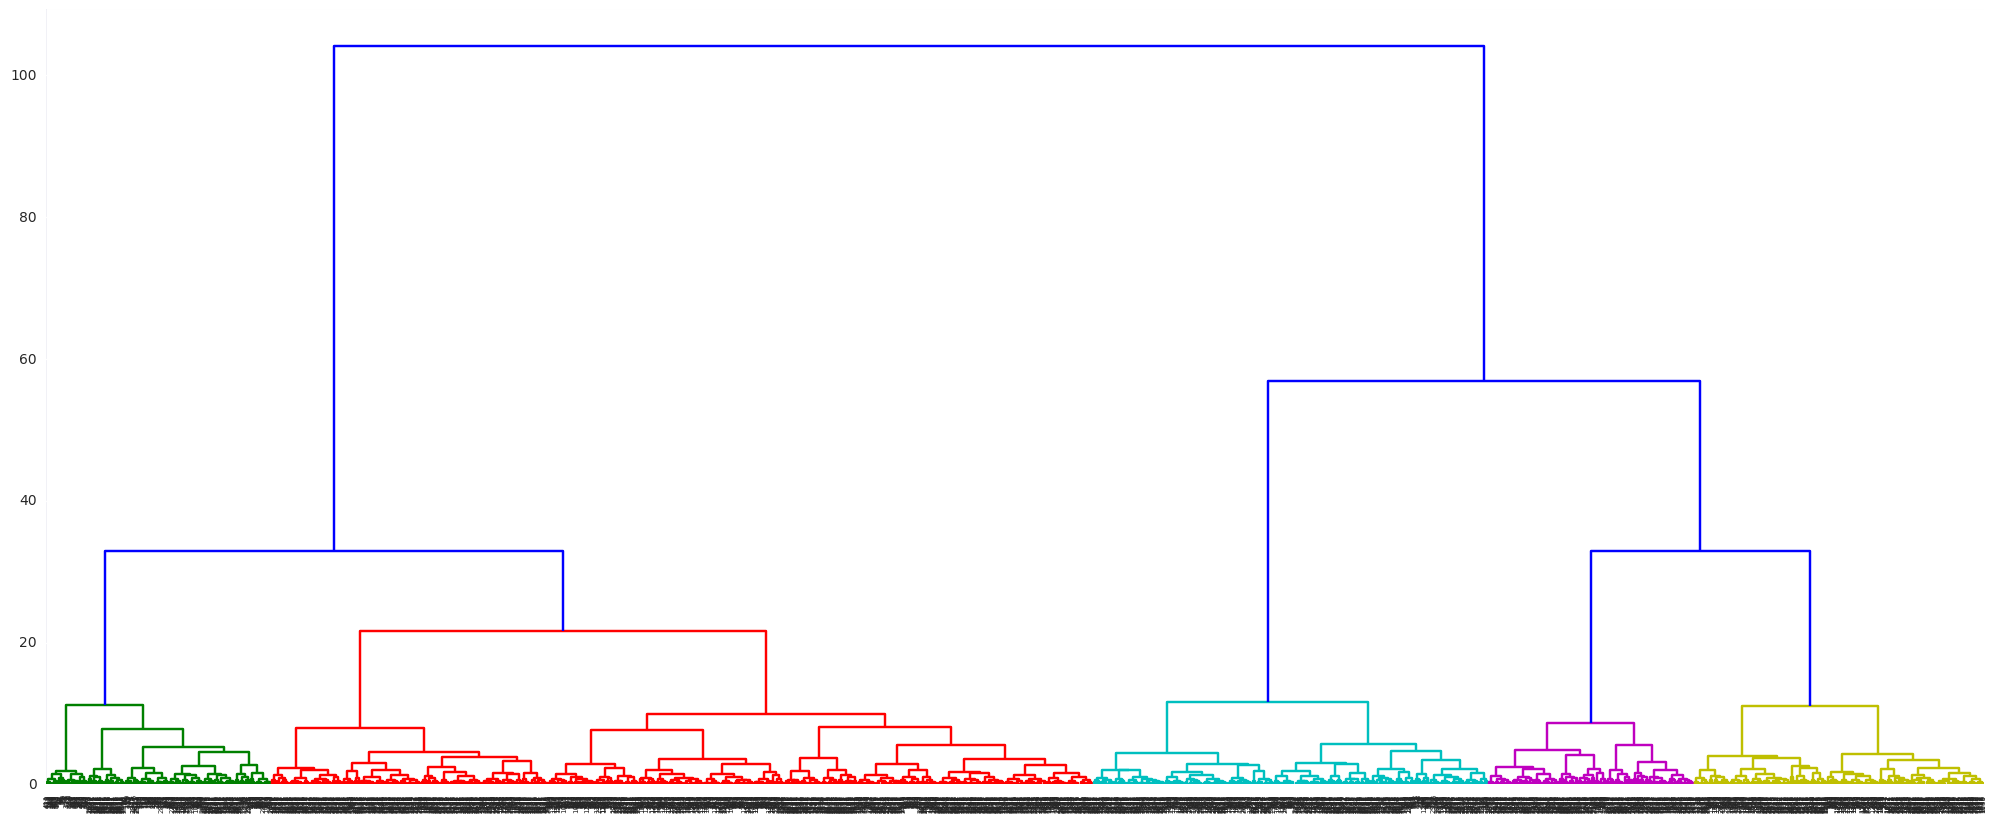

In [9]:
# plot the dendrogram colored by a certain height
hcut = 25
fig = plt.figure(figsize=(25, 10))
hdend = hier.dendrogram(hclust_intuit,
                        color_threshold=hcut,
                        leaf_rotation=90)

With this clustering, there are 5 clear clusters. I'll project the cluster labels back onto the original feature axes using the crossplot function below.

In [10]:
# create function for cross plots
def xplot3(dataframe3, ax0, ax1, ax2, *label):
    """Create crossplots of over three variables
    
    Input:
        dataframe3: pd dataframe
        ax0: feature string 1
        ax1: feature string 2
        ax2: feature string 3
        label: optional color label (if not specified then plots the third axis)
        
    Outputs:
        crossplots over all combinations of three features
    """
    # check if color label
    if label:
        col = [label[0] for ii in range(3)]
    else:
        col = [dataframe3[ax2], dataframe3[ax0], dataframe3[ax1]]

    # initialize subplots and feature vector
    fig, ax = plt.subplots(1, 3, figsize=(18, 4))
    axes = [ax0, ax1, ax2, ax0, ax1]
    
    # loop over figures
    for ii in range(3):
        pp = ax[ii].scatter(dataframe3[axes[ii]],
                            dataframe3[axes[ii+1]],
                            c=col[ii],
                            cmap="jet",
                            alpha=0.2)
        ax[ii].set_xlabel(axes[ii])
        ax[ii].set_ylabel(axes[ii+1])
        if label:
            plt.colorbar(pp, ax=ax[ii])
        else:
            plt.colorbar(pp, ax=ax[ii], label=axes[ii+2])
    
    plt.show()
    
    # clean up
    return

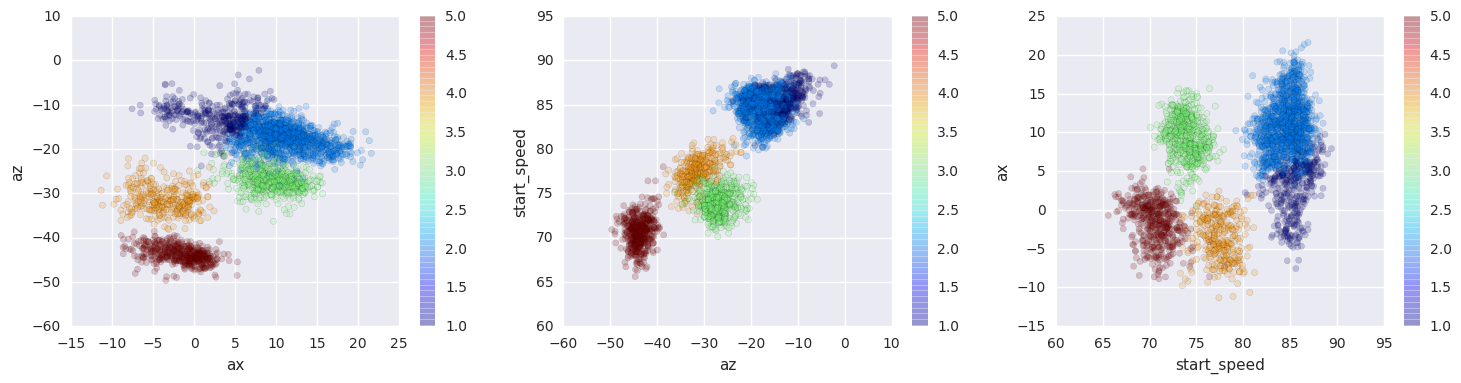

In [11]:
# labels
hlabel_intuit5 = hier.fcluster(hclust_intuit, hcut, 'distance')

# plot
xplot3(bz_pfxc, "ax", "az", "start_speed", hlabel_intuit5)

The cluster classifications look reasonable. Interestingly, the large cluster at the highest velocities got split into two clusters. Based on the feature values associated with each of these clusters, the dark blue group is likely his four-seam fastball, the light blue cluster is likely his two-seam fastball (which tails from left to right), the green cluster is likely his changeup, the orange cluster is likely his slider (breaks right to left), and the red cluster is likely his curveball.

These pitch classification descriptions are based on the pitch chart in https://www.fangraphs.com/library/pitch-type-abbreviations-classifications/ (flipped for left-handed pitchers).

I'll compare these results to the pitch classifications from the database.

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


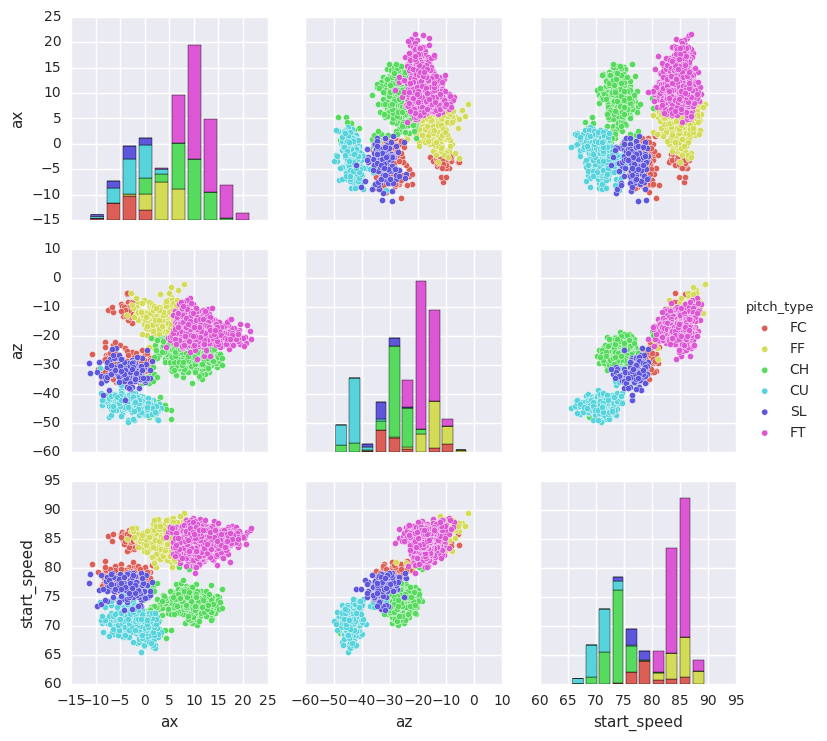

In [12]:
# pitch type from database
pitches_intuit["pitch_type"] = bz_pfxc["pitch_type"]
sns.pairplot(data=pitches_intuit,
             hue="pitch_type",
             palette="hls")
pitches_intuit = pitches_intuit.drop("pitch_type", 1)
plt.show()

The pitch classifications from the database are quite different than pitch classification from clustering. Looking at `ax` vs `start_speed`, the cutter (red) is found in both the primary clusters for the four-seamer (yellow) and the slider (blue). While it is possible that the cutter does exist, it is difficult to believe that its trajectory is that similar to his slider. Therefore, it looks like the clustering algorithm might be doing a better job than what was provided by the database, although with one fewer pitch type.

However, since the database suggests there are six pitch types, I'll go back and pull out the sixth cluster from the hierarchical clustering and plot the resulting labels.

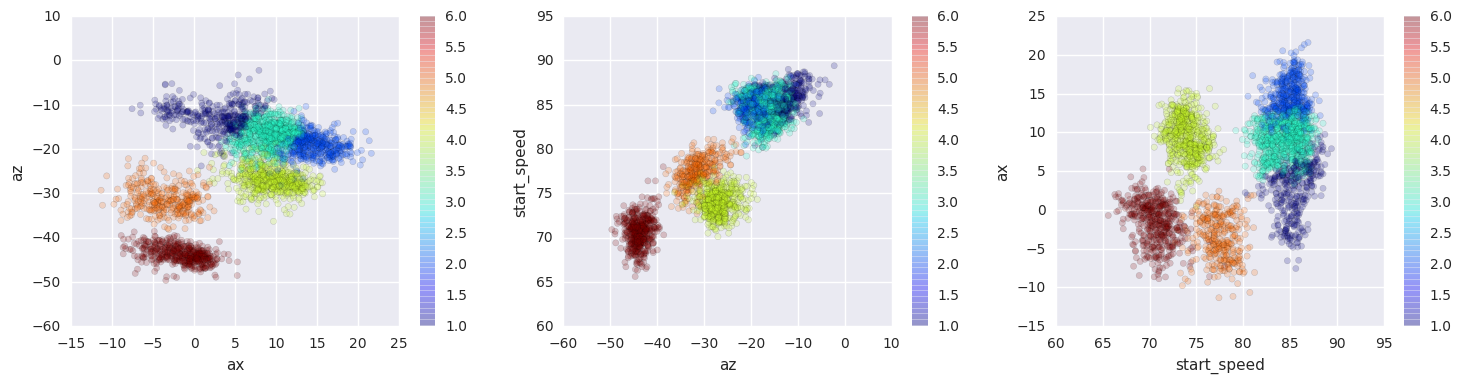

In [13]:
# labels
hcut = 18
hlabel_intuit6 = hier.fcluster(hclust_intuit, hcut, 'distance')

# plot
xplot3(bz_pfxc, "ax", "az", "start_speed", hlabel_intuit6)

With six clusters, I actually see the probable cutter being separated (dark blue). It has similar horizontal acceleration as the slider and curveballs but has velocity comparable to his two other fastballs.

Therefore, I am confident that Barry Zito has five pitches (four-seam, two-seam, changeup, slider, curveball), and potentially a sixth pitch (cutter) with less confidence. Overall, these appear to be better classifications than those from the database, as I do not have multiple pitches grouped into the same cluster (like the database shows when plotting horizontal acceleration against start speed).

### Based on trajectory features

Now I'll look at the clustering results when all the trajectory features are included. I'll run the same workflow as before using Ward linkage and Euclidean distance.

In [14]:
# generate linkage matrix
hclust_all = hier.linkage((bz_pfxc.iloc[:, :-1]-bz_pfxc.iloc[:, :-1].mean())/bz_pfxc.iloc[:, :-1].std(),
                           method='ward',
                           metric='euclidean',)

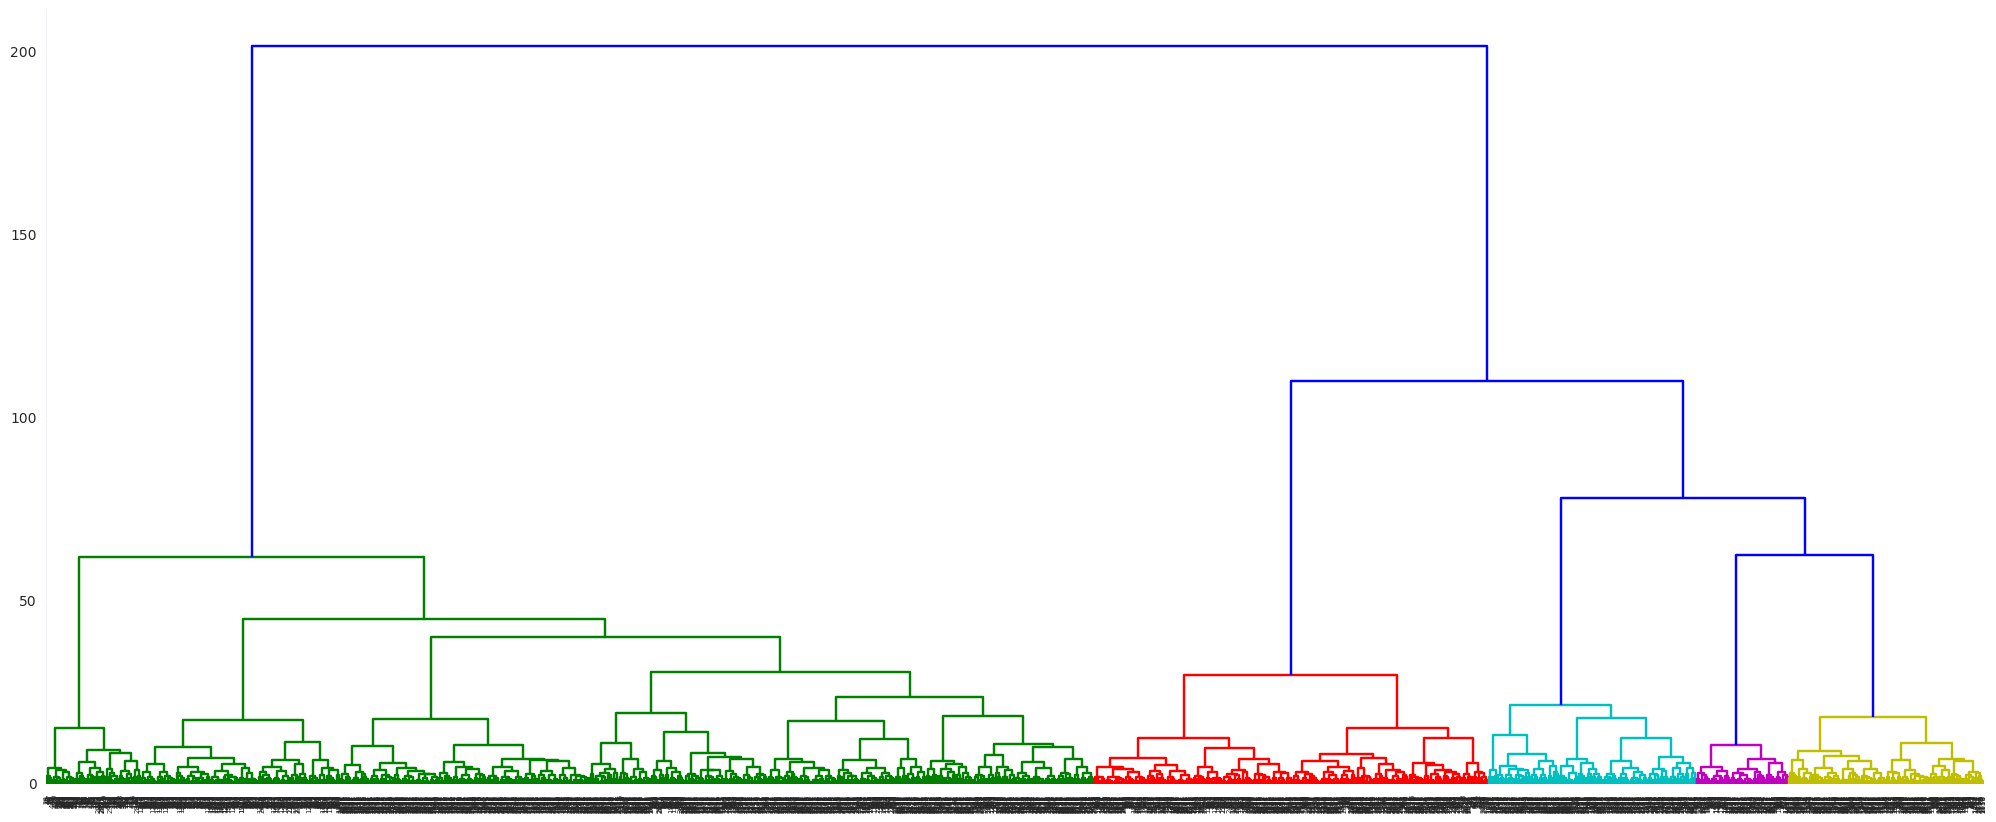

In [15]:
# plot the dendrogram colored by a certain height
hcut = 62.5
fig = plt.figure(figsize=(25, 10))
hdend = hier.dendrogram(hclust_all,
                        color_threshold=hcut,
                        leaf_rotation=90)

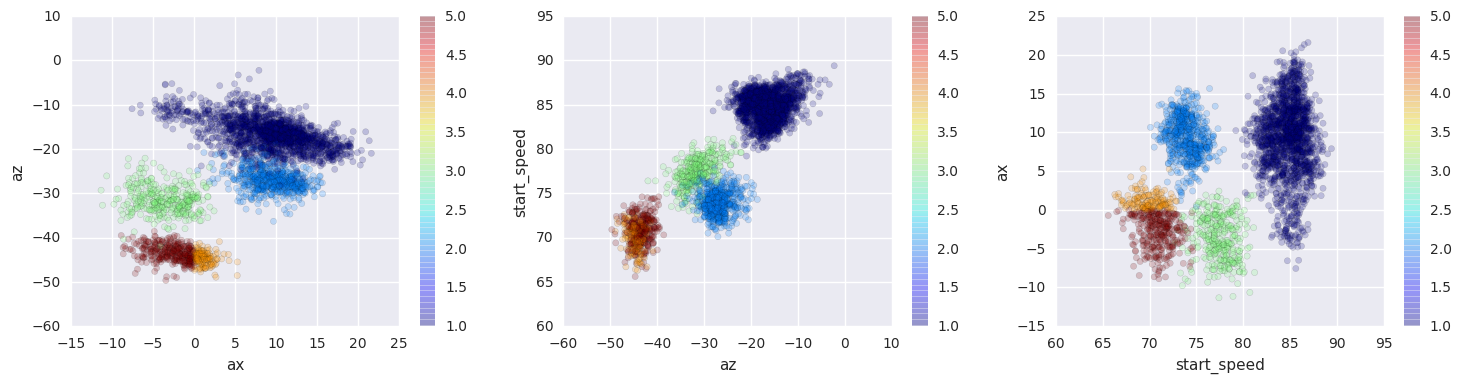

In [16]:
# labels
hlabel_all = hier.fcluster(hclust_all, hcut, 'distance')

# plot
xplot3(bz_pfxc, "ax", "az", "start_speed", hlabel_all)

There are actually some clear clusters when using all trajectory-related features. However, when trying to distinguish a fifth cluster, the curveball cluster (red) is actually spilt into two clusters. Compared to the labels from the dataset and the clustering results using intuition, it is unlikely that this particular cluster should be split in two.

The curse of dimensionality is likely at play here, as data points become more spread out in higher dimensions and appear "less similar" to each other. Thus, any clustering algorithm based on a distance metric will be negatively impacted, as it will be less clear how to group observations together.

### Based on PCA space 

Next, instead of throwing all the features into a clustering algorith, I will look to reduce the number of dimensions in the data first. This is because I want to avoid the curse of dimensionality, which was in action in the previous section.

I will use PCA to find a lower-dimensional representation of the data that explains as much of the variance as possible. PCA should also help avoid problems from using highly-correlated features.

In [17]:
# import pca
from sklearn.decomposition import PCA

# standardize features
bz_pfxc_stand = (bz_pfxc.iloc[:, :-1]-bz_pfxc.iloc[:, :-1].mean())/bz_pfxc.iloc[:, :-1].std()

# initialize and perform pca
pca = PCA(whiten=False)
bz_pfxc_pca = pca.fit(bz_pfxc_stand)

I'll plot the proportion of variance explained by each principal component.

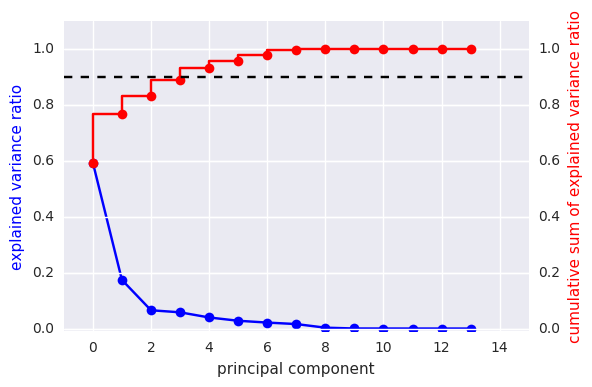

In [18]:
# plot variance ratio against principal component
fig, ax1 = plt.subplots()
ax1.plot(bz_pfxc_pca.explained_variance_ratio_, "o-", color="b")
ax1.set_xlabel("principal component")
ax1.set_ylabel("explained variance ratio")
ax1.set_ylim([-0.01, 1.1])
ax1.yaxis.label.set_color('b')

# plot cumulative sum of explained variance ratio against principal component
ax2 = ax1.twinx()
ax2.step(np.cumsum(bz_pfxc_pca.explained_variance_ratio_), "o-", color="r")
ax2.set_ylabel("cumulative sum of explained variance ratio")
ax2.set_xlim([-1, 15])
ax2.set_ylim([-0.01, 1.1])
ax2.yaxis.label.set_color('r')
ax2.axhline(y=0.9, color="k", ls="dashed")
plt.show()

The first two principal components already account for more than 75% of the variance in the data. Starting from the third principal component, there is a steep dropoff in the proportion of variance explained.

Next, I'll take a look at the loadings of the first four principal components to get a sense of which features they are most sensitive to.

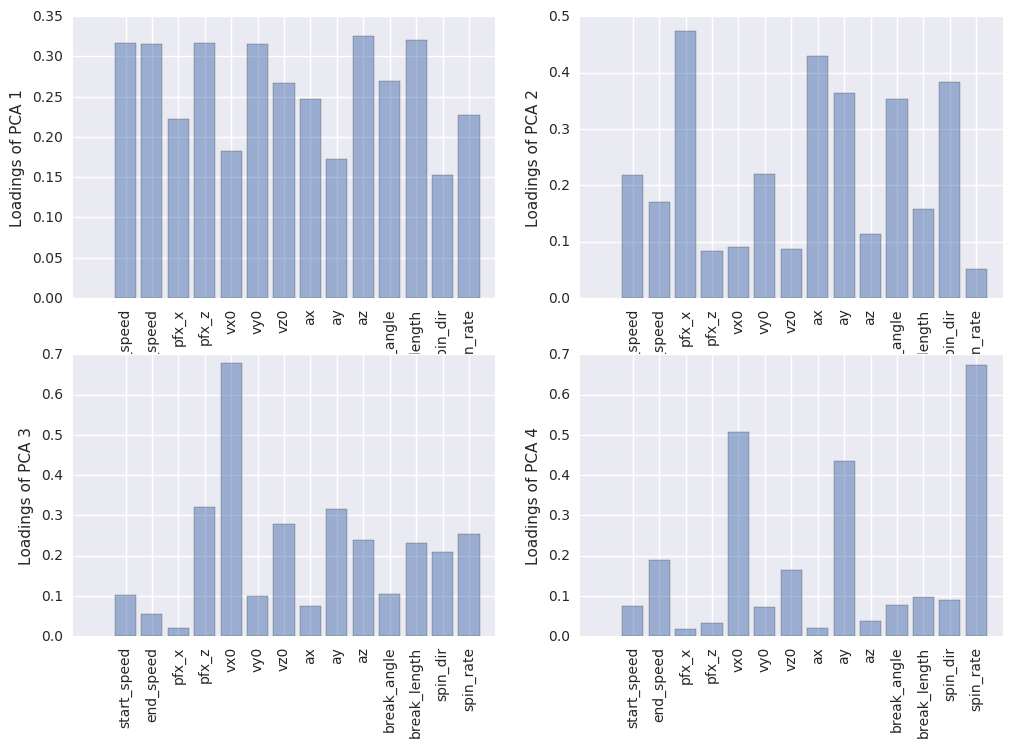

In [19]:
# intialize figure
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# plot loadings
for ii in range(2):
    for jj in range(2):
        loadings = bz_pfxc_pca.components_[2*ii+jj, :]
        # plot barchart of loadings
        ax[ii, jj].bar(range(len(loadings)), np.abs(loadings), align='center', alpha=0.5)
        ax[ii, jj].set_ylabel("Loadings of PCA %s" %(2*ii+jj+1))
        plt.sca(ax[ii, jj])
        plt.xticks(range(len(loadings)), list(bz_pfxc), rotation=90)
plt.show()

The first principal component is a measurement of mostly the velocity and vertical movement, the second is a measurement of primarily the horizontal movement, the third is a measurement of the horizontal velocity, and the fourth is a measurement of the spin rate.

I will perform hierarchical clustering using just the information from the first four principal components, so that nearly 90% of the variance in the data is explained. The dimension of the data is reduced from 13 to 4.

In [20]:
# calculate the scores
bz_pfxc_pca_fit = np.dot(bz_pfxc_stand, bz_pfxc_pca.components_.T)

# scale the scores
bz_pfxc_pca_stand = (bz_pfxc_pca_fit-bz_pfxc_pca_fit.mean(axis=0))/bz_pfxc_pca_fit.std(axis=0)

In [21]:
# perform clustering on first four principal components
hclust_pc4 = hier.linkage(bz_pfxc_pca_stand[:, :4],
                          method='ward',
                          metric='euclidean')

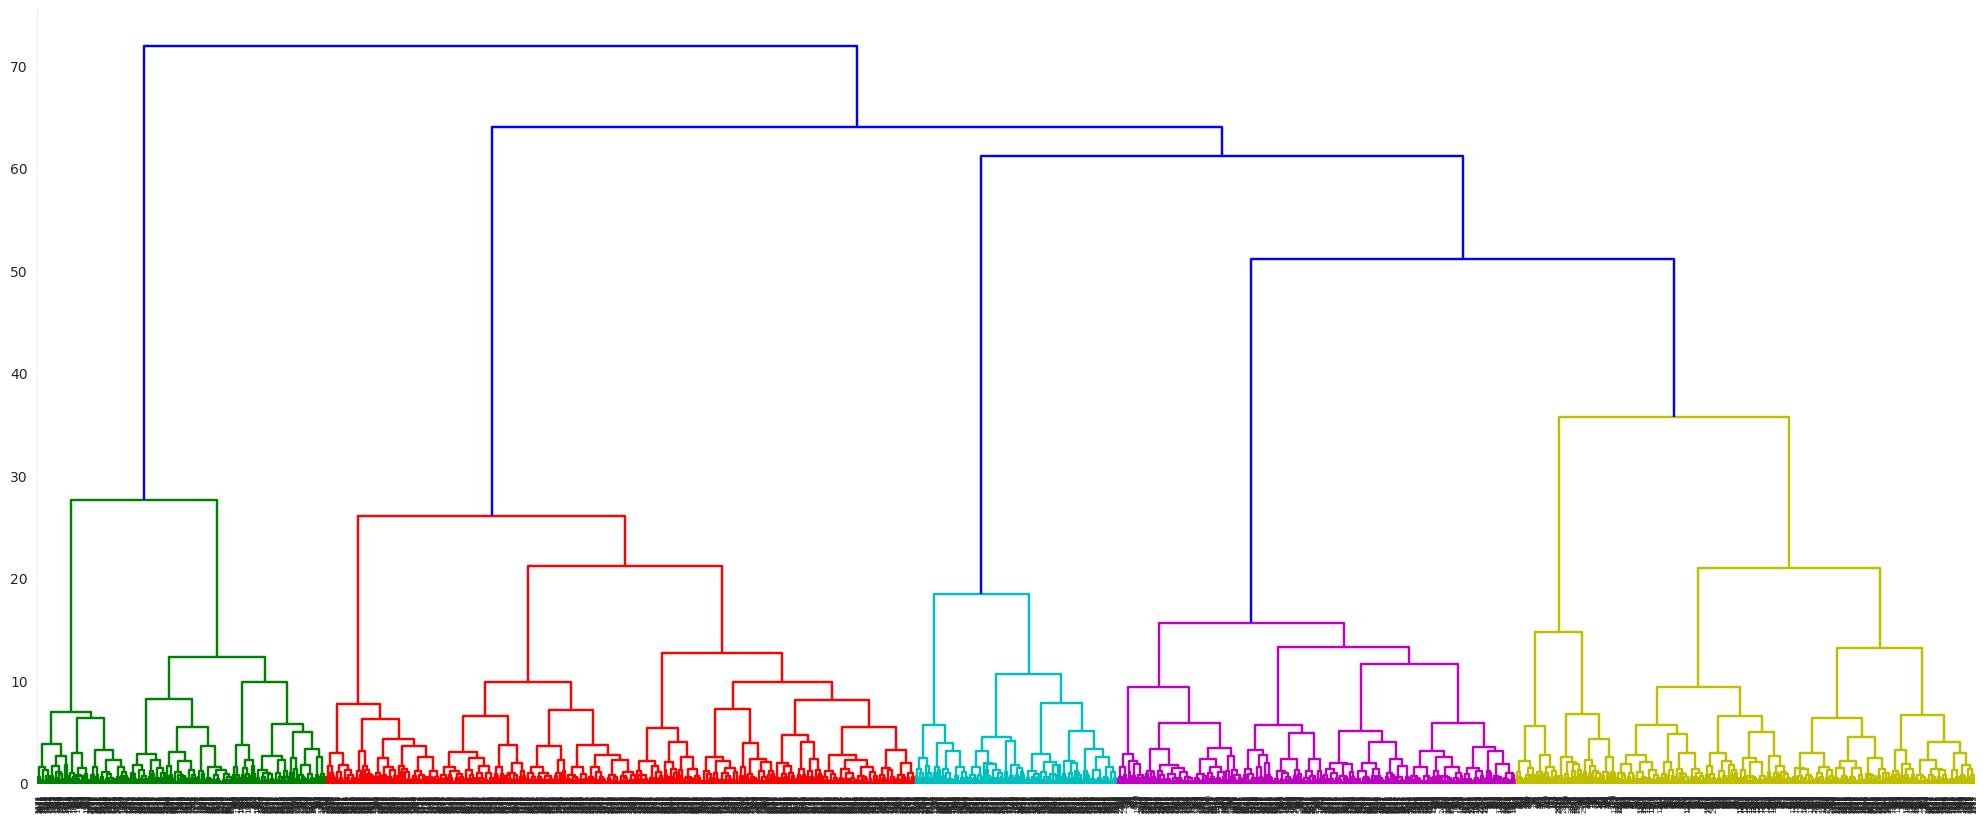

In [22]:
# plot the dendrogram colored by a certain height
hcut = 45
fig = plt.figure(figsize=(25, 10))
hdend = hier.dendrogram(hclust_pc4,
                        color_threshold=hcut,
                        leaf_rotation=90)

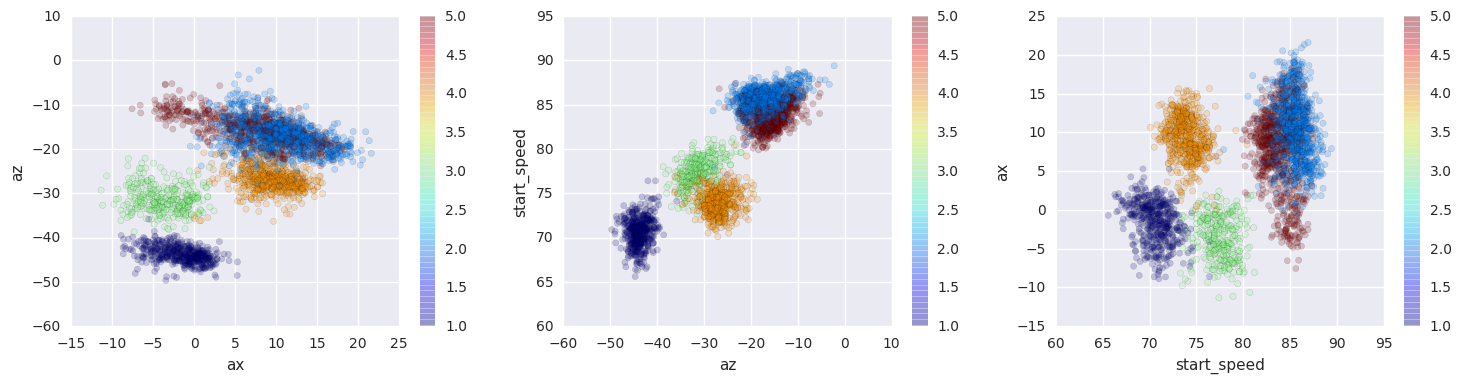

In [23]:
# get cluster labels
hlabel_pc4 = hier.fcluster(hclust_pc4, hcut, 'distance')

# plot
xplot3(bz_pfxc, "ax", "az", "start_speed", hlabel_pc4)

Clustering results in PCA space show a relatively good job finding five clusters. They appear to be the clusters related to the four-seamer (light blue), two-seamer (red), changeup (orange), slider (green), and curveball (dark blue). These are similar results when using intuition for selecting clustering features, although there is some difference in the ratio of four-seamers and two-seamers. Overall, it seems that PCA can be effective in reducing the dimension of the data for clustering purposes.

Now I'll look at how the clustering looks when using three principal components.

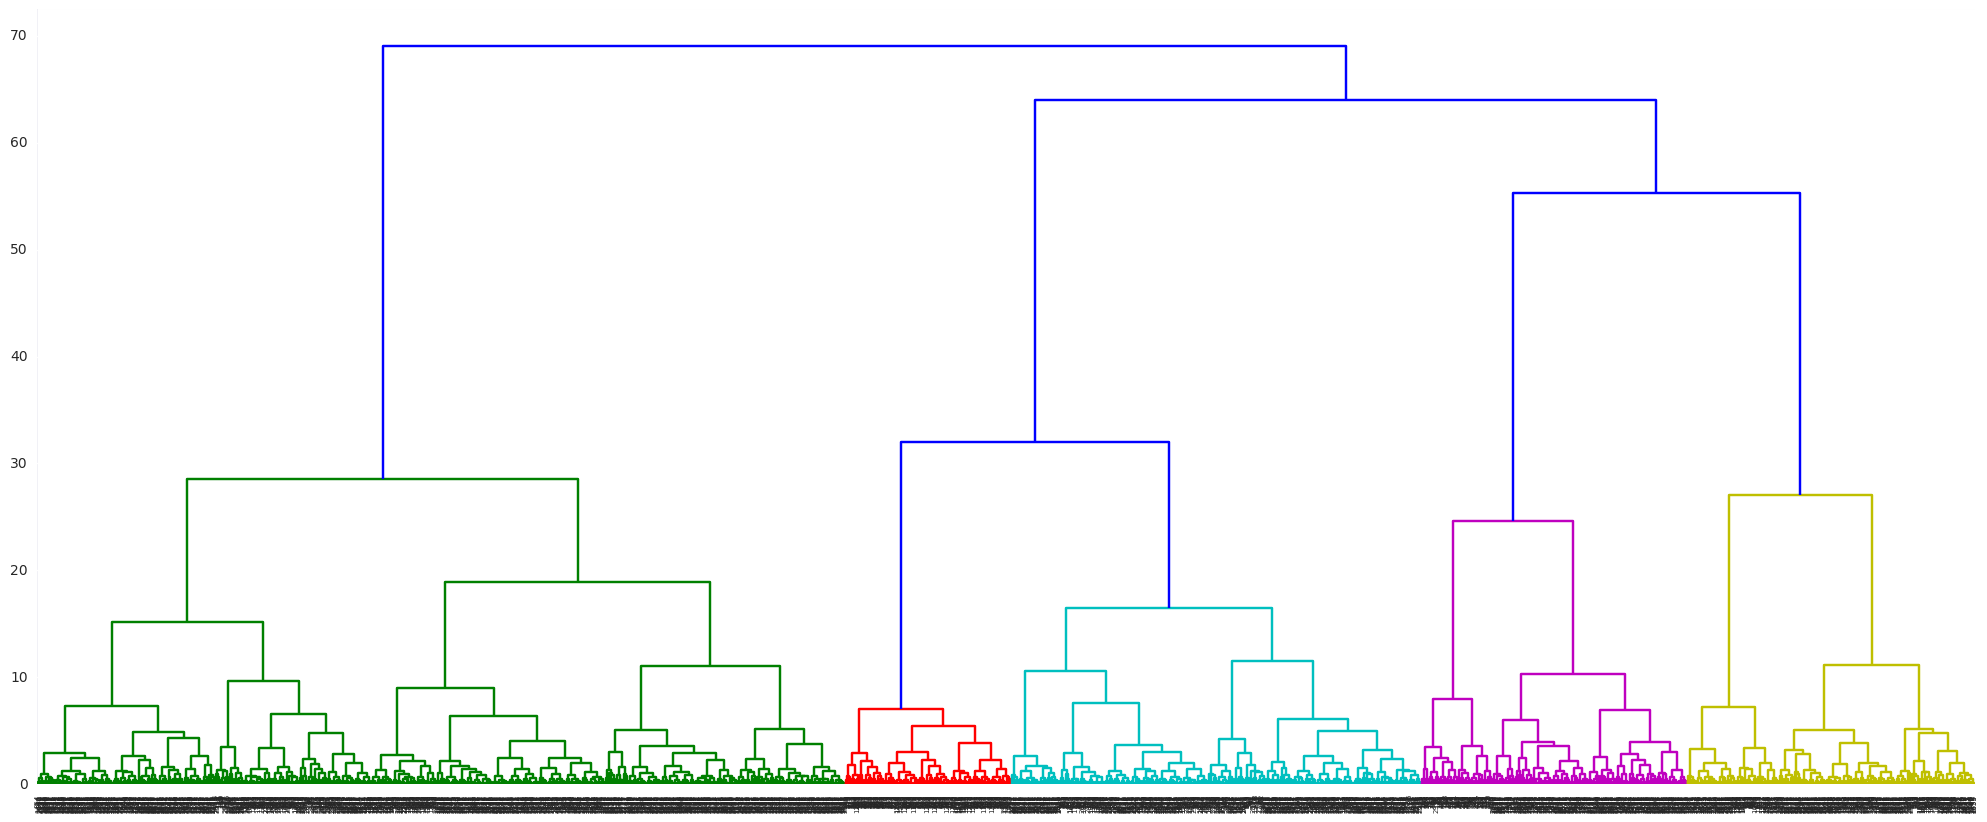

In [24]:
# perform clustering on first four principal components
hclust_pc3 = hier.linkage(bz_pfxc_pca_stand[:, :3],
                          method='ward',
                          metric='euclidean')

# plot the dendrogram colored by a certain height
hcut = 30
fig = plt.figure(figsize=(25, 10))
hdend = hier.dendrogram(hclust_pc3,
                        color_threshold=hcut,
                        leaf_rotation=90)

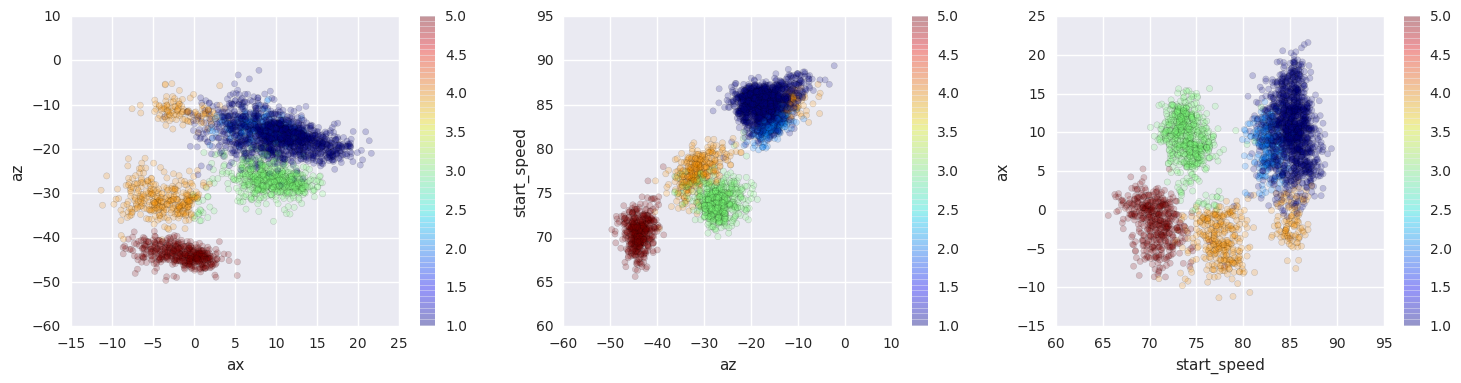

In [25]:
# get cluster labels
hlabel_pc3 = hier.fcluster(hclust_pc3, hcut, 'distance')

# plot
xplot3(bz_pfxc, "ax", "az", "start_speed", hlabel_pc3)

When using three principal components, the five clusters are less convincing than when using four principal components. The slider (orange) is split across two clear clusters, while the four-seamer (light blue) is hidden in the two-seamer (dark blue) cluster.

Thus, the quality of the clustering appears to be highly dependent on the number of principal components used in the analysis. While fewer principal components lead to data points being more condensed (and hence more meaningfully clustered), less of the variance in the data is explained. On the other hand, while more principal components describe more variance in the data, the data points are more spread out (and hence less meaningful when clustered).

Overall, using all trajectory features for classifying pitch types can be harmful to the clustering results. PCA can be used to decorrelate features and avoid the curse of dimensionality, but the method's goal is to explain the variance of the data in a lower dimension, not separate clusters in the data. While clustering in principal-component space can lead to reasonable clusters, the quality of the clustering appears highly dependent on the number of principal components kept. Thus, for the particular case of pitch classification, it appears best to cluster pitches using features based on intuition (starting velocity and vertical/horizontal acceleration).

Of course, every pitcher has a different set of pitches at his disposal. So while Barry Zito has arguably 5 different pitches, others will have more or less. Hierarchical clustering is useful when exploring the data for clusters of pitches, but it is difficult to automate what the cut-off height should be. Therefore, I look to develop an automatic pitch clustering approach where the number of pitches is unknown.

## Automatic pitch classification using DBSCAN with K-means clustering

Using the previous analysis for one pitcher is feasible, at it is easy to tune parameters (i.e., number of pitches via cut-off height). However, when there are many pitchers to work with, tuning clustering parameters by hand for each pitcher becomes unfeasible. Here, I attempt to create an automatic pitch clustering procedure for any pitcher using DBSCAN and K-means together.

Density-based spatial clustering of applications with noise (DBSCAN) groups together data observations that are close together. This approach has the advantages that the number of clusters beforehand does not need to be known, it is robust to outliers (or noise features that are not truly associated with the response), and it can find arbitrarily shaped clusters. Therefore, this is a reasonable approach for determining the number of clusters when it is not known apriori.

In the case of pitch classification, I'd like every pitch to have a label. While DBSCAN finds clusters, it will also label outliers. I'd like those outliers to also have labels as pitch types. Therefore, I will run one iteration of K-means clustering using centroids estimated from the results of DBSCAN.

### DBSCAN

This particular clustering method builds clusters based on density and proceeds as follows:

1) Make an n-dimensional sphere of radius epsilon around the point and count the number of data points within the sphere.

2) If the number of points within the sphere are more than *min_points* then we mark the center of the sphere to be belonging to a cluster. We also mark the points inside the sphere to be belonging to the same cluster. We then recursively expand the cluster by applying the same criteria to the points inside the sphere, except the center.

3) In case the number of points inside the sphere are less than min_points, we ignore it and proceed to the next point in the dataset.

There are three primary parameters for this method. First, there is a distance metric, which I take to be Euclidean distance. Second, there is the minimum number of data points within a region needed to create a dense cluster (`min_points`). A rule of thumb is that this value should be at least twice the dimension of the data set. Here, I will scale the dimension of the dataset by the number of pitches divided by 1000 (chosen manually through examination of multiple pitchers). The reasoning behind this is that as more pitches are thrown, there should be denser clusters (hence a higher `min_points` requirement for a core point). Third, there is the maximum distance between two samples for data observations to be considered as in the same neighborhood (`eps`). This value can be estimated from looking for an elbow point on a K-distance plot (i.e., sorted distances between each data point and its `min_points`-th nearest neighbor).

In [26]:
# imports
from sklearn.neighbors import NearestNeighbors

# standardize intuitive features
pitches_intuit_stand = (pitches_intuit-pitches_intuit.mean())/pitches_intuit.std()

# set min_points parameter
scale = np.rint(pitches_intuit_stand.shape[0]/1000)
min_points = int(scale*pitches_intuit_stand.shape[1])

# initialize nearest-neighbor object
nbrs = NearestNeighbors(n_neighbors=min_points,
                        metric="euclidean")

# fit nearest-neighbors
nbrs_fit = nbrs.fit(pitches_intuit_stand)
kdist, kind = nbrs_fit.kneighbors(pitches_intuit_stand)

Typically, the maximum distance between samples (`eps`) is estimated as the "elbow" of the sorted distances for the `min_points`-th nearest neighbors. I'll pick the `eps` value to be the 80th percentile of distances for now (as a simple attempt to automate the selection of `eps`) and run DBSCAN with Euclidean distance as the metric.

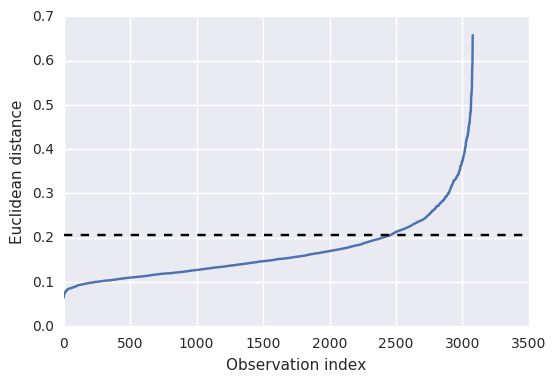

In [27]:
# get distances and sort
kk = np.sort(kdist[:, -1])

# set percentile cutoff
q = 80

# plot sorted distance as a function of data point index
plt.plot(kk)
plt.xlabel("Observation index")
plt.ylabel("Euclidean distance")
plt.axhline(y=np.percentile(kk, q=q),
            color='k',
            ls='dashed',)
plt.show()

In [28]:
# initialize variables
from sklearn.cluster import DBSCAN
eps = np.percentile(kk, q=q)

# initialize dbscan object
dbscan = DBSCAN(eps=eps,
                min_samples=min_points,
                metric="euclidean",)

# fit and predict labels with dbscan
label_dbscan = dbscan.fit_predict(pitches_intuit_stand)

Let's look at the initial cluster labels from DBSCAN in feature space.

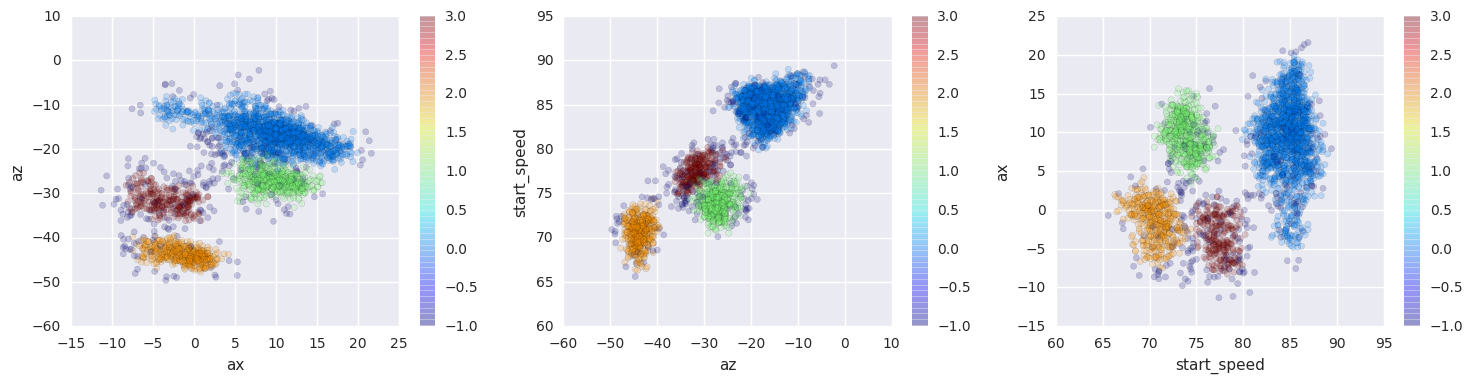

In [29]:
# plot
xplot3(bz_pfxc, "ax", "az", "start_speed", label_dbscan)

There are four distinct clusters that actually correspond well with the clusters obtained with hierarchical clustering. I can easily pick out the fastball (blue), changeup (green), slider (red), and curveball (orange) clusters. Though the Zito seems to throw at least two types of fastballs, this method with these parameters currently groups those into one cluster. However, there are a number of outliers that are not labeled. Since I would like to label all pitches, I will use the number of clusters from the DBSCAN result and the corresponding cluster centroids as a starting point for K-means clustering.

### K-means clustering

K-means clustering is an iterative clustering process that estimates a label for all data points. Its procedure has the following steps.

1) Assign K data points randomly to be starting centroids (where K is the number of clusters desired).

2) Assign the remaining data points to those centroids based on a chosen distance metric.

3) Calculate the new cluster centroid locations based on the mean locations of the data points assigned to each respective cluster.

4) Repeat steps 1-3 until the centroid locations don't change or until a maximum number of iterations is run.

Two issues with K-means clustering is that the user must decide the number of clusters beforehand, and that the algorithm's solution can fall into a local minimum. However, using DBSCAN beforehand solves both of these problems, as the number of clusters and ideal starting cluster centroids will have already been estimated. I will one run iteration of K-means clustering to label the outliers.

In [30]:
# create labeled dataframe
bz_pfxc_stand_labeled = pd.concat([pitches_intuit_stand.reset_index(drop=True),
                                   pd.Series(label_dbscan, name="ptype")],
                                   axis=1)

# calculate centroids and number of clusters
centroids_init = bz_pfxc_stand_labeled.groupby("ptype").mean().iloc[1:, :]
k = centroids_init.shape[0]

In [31]:
# import package
from sklearn.cluster import KMeans

# perform K-means
label_kmeans = KMeans(n_clusters=k,
                      init=centroids_init,
                      n_init=1).fit_predict(pitches_intuit_stand)

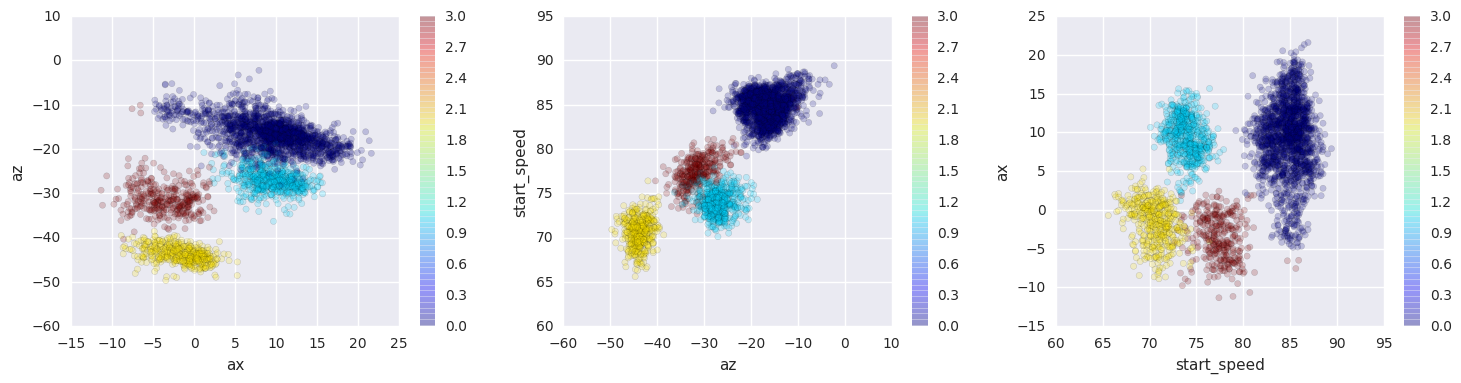

In [32]:
# plot
xplot3(bz_pfxc, "ax", "az", "start_speed", label_kmeans)

Thus, I have labeled all the pitches, including the outliers from DBSCAN. Note that for the most part, the outliers from DBSCAN are just pitches relatively far away from the cluster centroids and are likely just poorly executed pitches.

Next, I'll look at how the automatic pitch clustering labels compare to those from the other clusterings previously done.

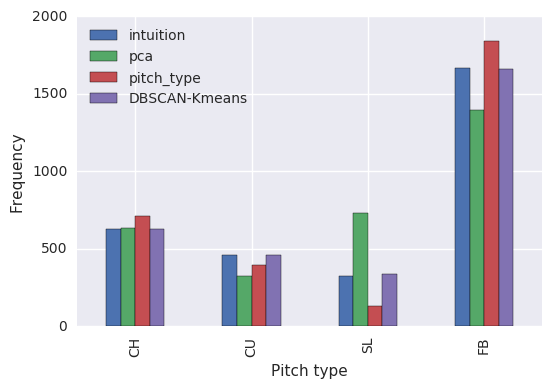

In [33]:
# label counts from database
pcount_database = bz_pfxc["pitch_type"].value_counts()

# label counts from intuition
count_intuit5 = np.bincount(hlabel_intuit5)
dcount_intuit5 = {"FT": count_intuit5[1],
                  "FF": count_intuit5[2],
                  "CH": count_intuit5[3],
                  "SL": count_intuit5[4],
                  "CU": count_intuit5[5]}

# label counts from pca
count_pc4 = np.bincount(hlabel_pc4)
dcount_pc4 = {"FT": count_pc4[1],
              "FF": count_pc4[2],
              "CH": count_pc4[4],
              "SL": count_pc4[5],
              "CU": count_pc4[3]} 

# convert dictionary to dataframe
pclass = pd.DataFrame([dcount_intuit5, dcount_pc4],
                       index=["intuition", "pca"])

# combine database classifications and clutering labels
pclass = pclass.append(pcount_database).fillna(0)

# combine columns
pclass["FB"] = pclass["FF"]+pclass["FC"]+pclass["FT"]

# create new dataframe for plotting
pclass_mod = pclass.drop(["FC",
                          "FT",
                          "FF"], 1)

# label counts from DBSCAN+Kmeans
count_dbk = np.bincount(label_kmeans)
dcount_dbk = {"FB": count_dbk[0],
              "CU": count_dbk[2],
              "CH": count_dbk[1],
              "SL": count_dbk[3],}

# create dataframe of counts
pclass_mod2 = pclass_mod.append(pd.Series(dcount_dbk, name="DBSCAN-Kmeans")).fillna(0)

# plot comparitive bar chart of pitch counts
pclass_mod2.transpose().plot.bar()
plt.xlabel("Pitch type")
plt.ylabel("Frequency")
plt.show()

Results are relatively similar to the clustering labels from intutive features and after PCA across the methods. Note that I have grouped all fastballs together into the `FB` category, as the boundary that distinguishes a four-seamer from a two-seamer is somewhat arbitrary.

Overall, this appears to be a promising approach for pitch clustering when the number of pitches is unknown.

### Examples

To make looking at other pitchers more easily, I will turn the DBSCAN with K-means approach into its own class (`DBSCANKMeans`). I will also create a `Player` class to make retrieval of pitches simpler. This player class can be expanded later to help make other tasks simpler (such as grabbing events and getting specific player attributes).

In [34]:
import sys
sys.path.append('../src')
from Player import Player
from DBSCANKMeans import DBSCANKMeans

#### Cliff Lee

In [35]:
# grab pitches
cl = Player("Cliff Lee", db)
cl_pfx = cl.pitches(clean=1)

# grab intuitive features
cl_pfx_intuit = cl_pfx[["ax",
                        "az",
                        "start_speed",]]

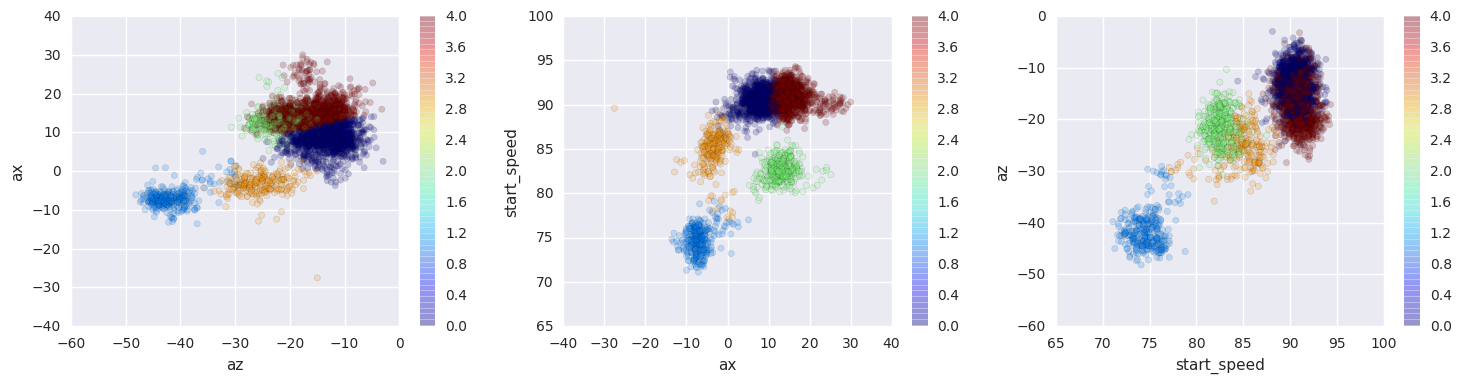

In [36]:
# cluster the pitches
dbk = DBSCANKMeans()
labels_dbk = dbk.fit_predict(cl_pfx_intuit, stand=1)
xplot3(cl_pfx, "az", "ax", "start_speed", labels_dbk)

With the default DBSCAN parameters, the pitches actually cluster fairly well into five groups. The blue is likely his curveball, the orange is likely his cutter (faster than his curveball, with more horizontal than vertical break), green is likely his changeup, red is likely his two-seamer, and blue is likely his four-seamer. However, again note that the distinction between the two-seamer and four-seamer is somewhat arbitrary. If I change the `eps` parameter to be larger (such that the search region around a data point is larger), then the fastball cluster appears as a single cluster.

I can now compare these pitch classifications to those from the database.

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


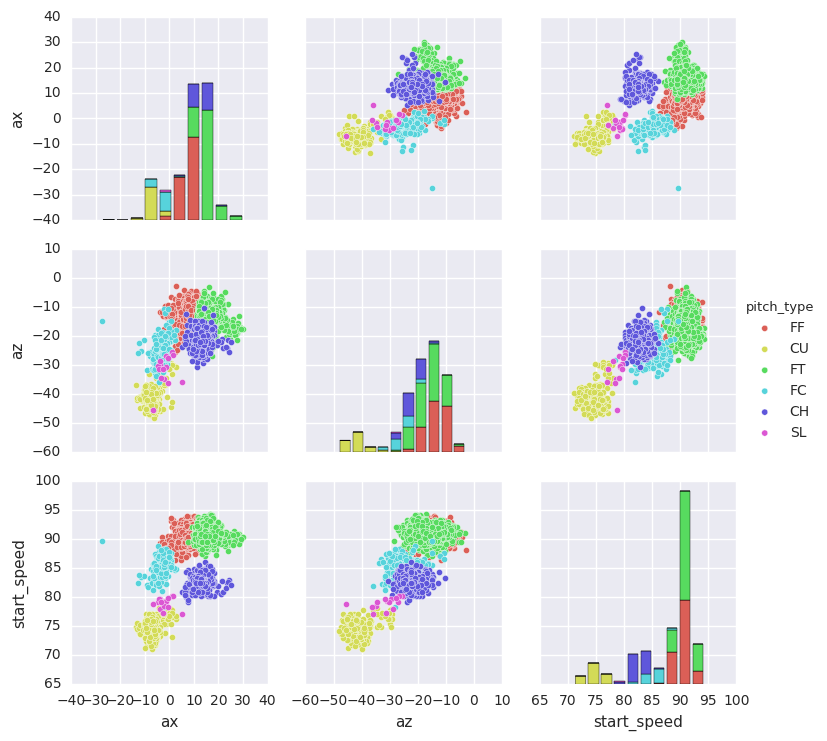

In [37]:
# pitch type from database
cl_pfx_intuit["pitch_type"] = cl_pfx["pitch_type"]
sns.pairplot(data=cl_pfx_intuit,
             hue="pitch_type",
             palette="hls")
plt.show()

The labels from the automatic clustering procedure compares fairly well to the database labels. However, the clustering approach identifies one fewer class of pitches (slider). While the slider may exist here, it is not thrown often enough to have its own cluster (not dense enough for DBSCAN).

#### Roy Halladay

In [38]:
# grab pitches
rh = Player("Roy Halladay", db)
rh_pfx = rh.pitches(clean=1)

# grab intuitive features
rh_pfx_intuit = rh_pfx[["ax",
                        "az",
                        "start_speed",]]

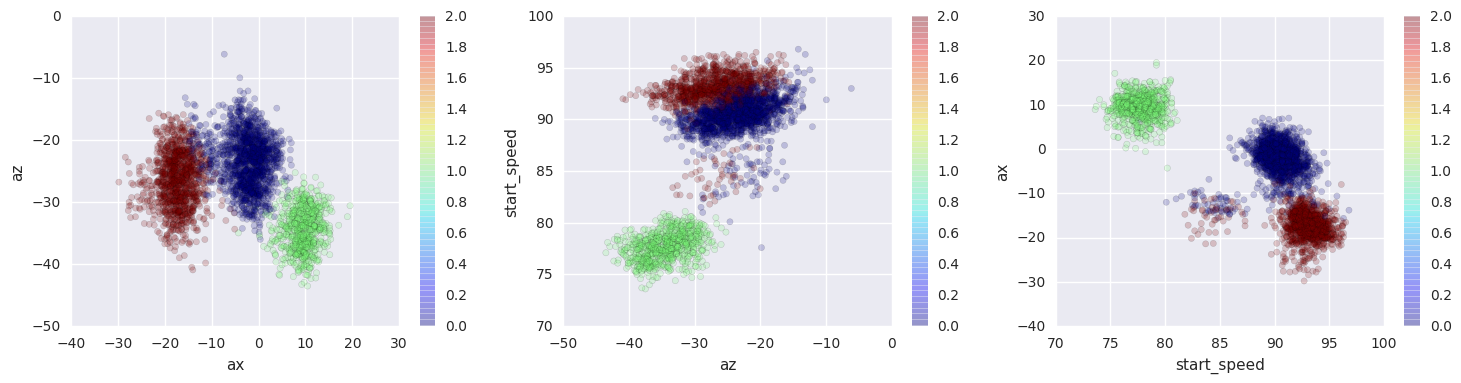

In [39]:
# cluster
dbk = DBSCANKMeans(q=80)
labels_dbk = dbk.fit_predict(rh_pfx_intuit, stand=1)
xplot3(rh_pfx, "ax", "az", "start_speed", labels_dbk)

While there are four clear clusters (look at start speed and horizontal acceleration), the DBSCAN-Kmeans clustering approach is only able to indentify three clusters. Regardless of how I tune the parameters, I am only able to pull out three clusters. If I lower the density threshold for a core point, I will be able to identify the small cluster, but the two larger clusters will split into even more clusters.

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


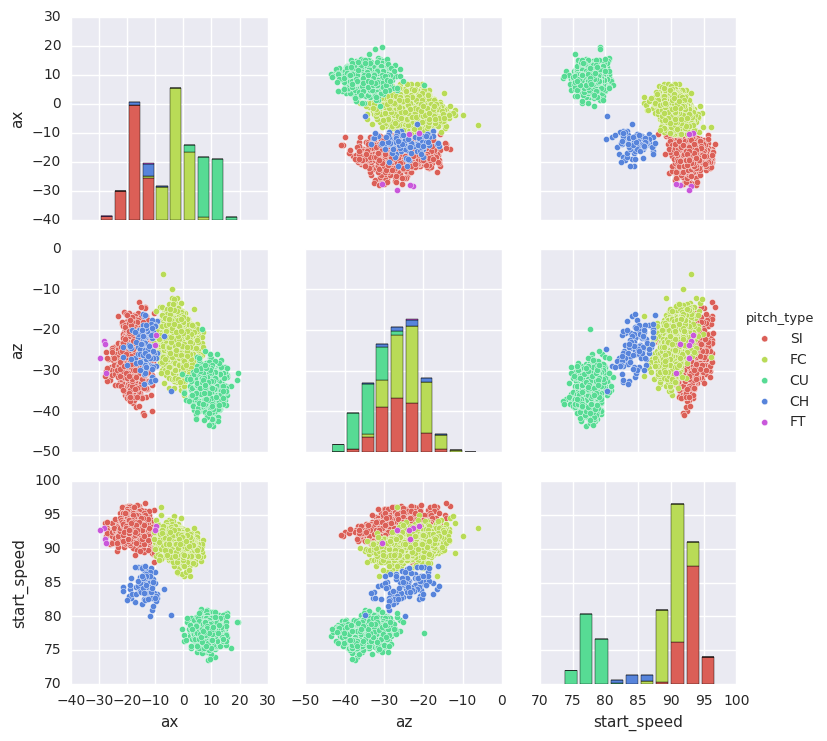

In [40]:
# pitch type from database
rh_pfx_intuit["pitch_type"] = rh_pfx["pitch_type"]
sns.pairplot(data=rh_pfx_intuit,
             hue="pitch_type",
             palette="hls")
plt.show()

The database labels suggests there are four clear pitch types, with a questionable classification of a two-seam fastball acting as a fifth pitch type.

Hence, this example exposes one of the problems with this DBSCAN-Kmeans approach: it does not handle clusters with different densities well. One possible solution is to include more years of pitch data and hope that changeup will be thrown more. I attempt to use a variable-density DBSCAN approach in a different notebook (*multidensity_dbscan*) with varying success.

#### Dan Haren

In [41]:
# grab pitches
dh = Player("Dan Haren", db)
dh_pfx = dh.pitches(clean=1)

# grab intuitive features
dh_pfx_intuit = dh_pfx[["ax",
                        "az",
                        "start_speed",]]

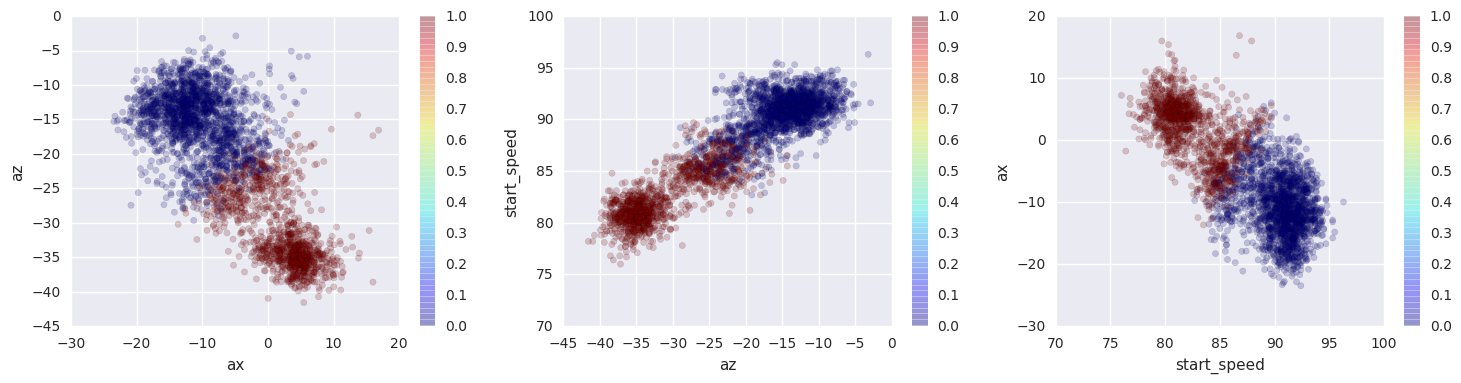

In [42]:
# cluster
dbk = DBSCANKMeans()
labels_dbk = dbk.fit_predict(dh_pfx_intuit, stand=1)
xplot3(dh_pfx, "ax", "az", "start_speed", labels_dbk)

Here, I run into more problems. There are three clear clusters, but only two have been identified. This shows another scenario where the method breaks down. Clusters that are not well separated can be grouped together, as the density threshold is low enough to allow the algorithm to bridge the gap between clusters. Here, I'll adjust the parameters by decreasing the `eps` parameter (through the percentile cutoff `q`), which determines the volume of the search region. I'm effectively increasing the density requirement for a core cluster point.

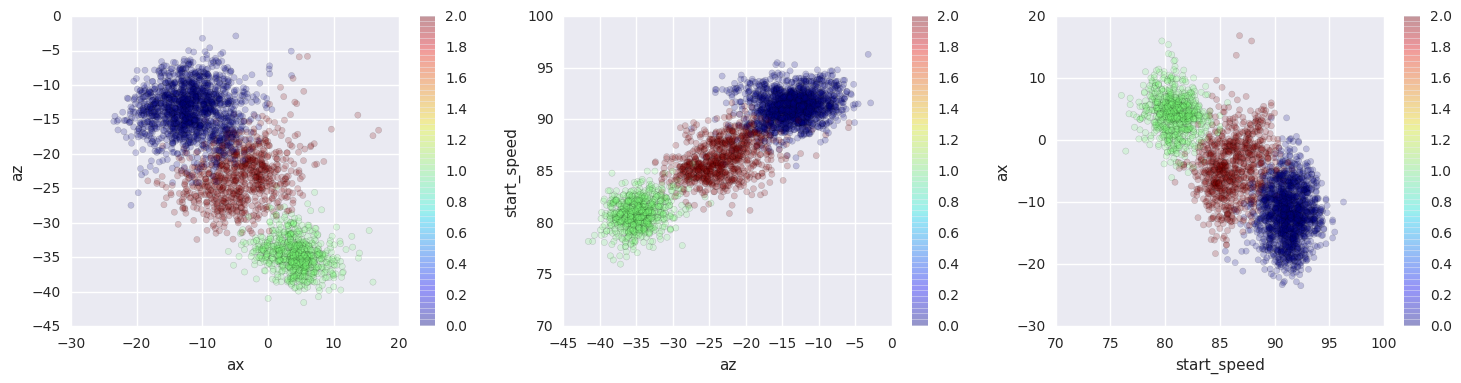

In [43]:
# cluster
dbk = DBSCANKMeans(q=71)
labels_dbk = dbk.fit_predict(dh_pfx_intuit, stand=1)
xplot3(dh_pfx, "ax", "az", "start_speed", labels_dbk)

After tuning the percentile of the `min_points` nearest neighbor for the `eps` parameter, I can pull out three clusters, like his fasball (blue), changeup (red), and curveball (green).

Now I'll look at the labels in the database.

/opt/conda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


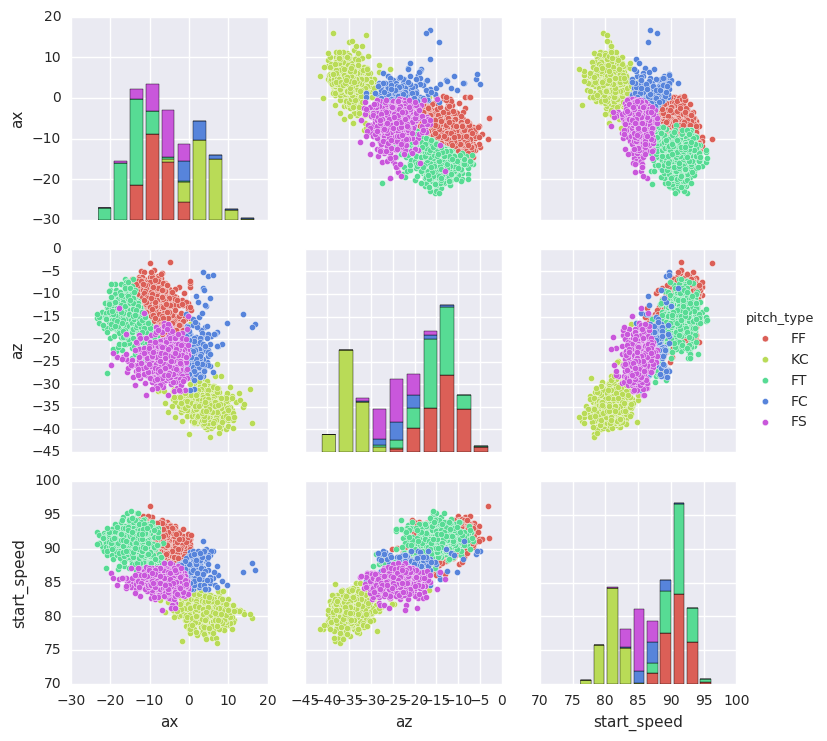

In [44]:
# pitch type from database
dh_pfx_intuit["pitch_type"] = dh_pfx["pitch_type"]
sns.pairplot(data=dh_pfx_intuit,
             hue="pitch_type",
             palette="hls")
plt.show()

There are five pitch types. Again, the fastball cluster is split into two. This time, though, the interpreted changeup cluster is divided into two different pitches as well. If I tune the `eps` parameter to be smaller (via percentile `q`), an interesting result emerges.

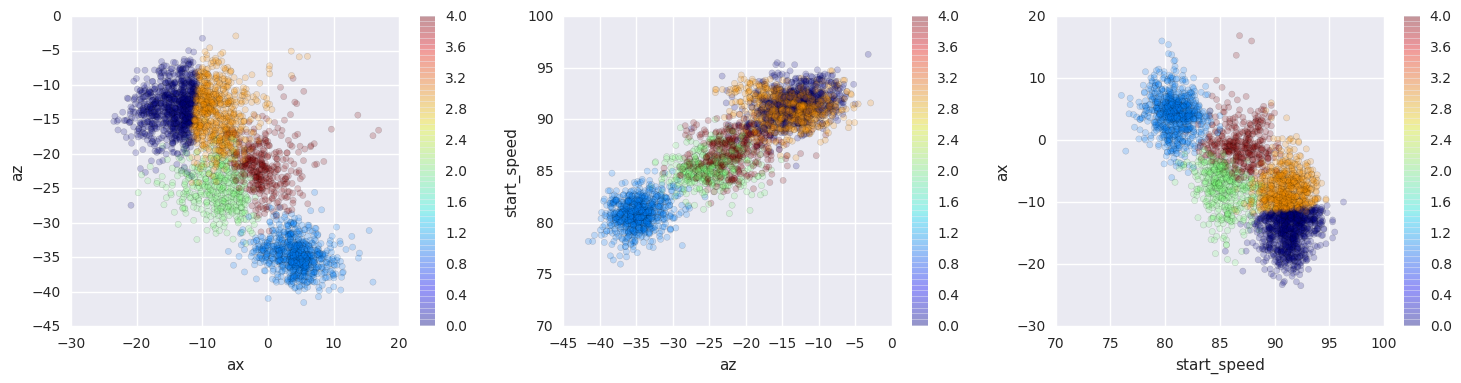

In [45]:
# modify data
dh_pfx_intuit = dh_pfx[["ax",
                        "az",
                        "start_speed",]]

# cluster
dbk = DBSCANKMeans(q=70)
labels_dbk = dbk.fit_predict(dh_pfx_intuit, stand=1)
xplot3(dh_pfx, "ax", "az", "start_speed", labels_dbk)

There are five clusters that match the database labels well. Therefore, this approach can be very sensitive to the `eps` parameter. I've decreased it here, which has increased the density requirement for a core point and has resulted in more clusters. Note that this does not mean the cluster labels are "correct"; it just means that they correspond well with the outputs of a different method of pitch classification. As discussed previously, there is no clear border where one pitch type begins and another pitch type begins (such as the four-seam and two-seam fastballs).

Overall, it appears that the method works well when clusters have similar densities and are somewhat well separated. If the former requirement is not met, this approach will unlikely be able to distinguish the sparse cluster. If the latter issue is not met, then tuning of the parameters is required (oftentimes decreasing `eps`).

In [46]:
# clean up
hdb.close()

## Final thoughts

If looking at an individual pitcher, pitch classification based on PitchFX data is manageable through clustering. Though there are parameters to tune (such as the number of pitches/clusters), it can easily be done manually (as seen with hierarchical clustering). However, generalizing an approach that works for all pitchers is a difficult task.

In the approach here, I combined DBSCAN and K-means clustering to try to automatically cluster pitchers using the velocity and acceleration features. In some cases it worked, and in other cases it did not.

### Strengths

The method here attempted to combine the best traits of DBSCAN and K-means. Results indicate that this method has the ability to effectively classify pitches automatically. I will outline some specific strengths of the method here.

1) The number of clusters is automatically detected. From these results, different pitch types are centered around different points in velocity-accelerations space, making it possible for DBSCAN to identify different clusters based on a set density criterion.

2) Model parameters can potentially be automatically selected. DBSCAN requires parameters to specify the minimum density criterion for starting/expanding a cluster. Though these parameters can by tuned for each pitcher, I've shown that they can also be automated based on the dimensions of the dataset to some success.

3) All points are labeled. All instances of a certain pitch type do not have the same trajectory. While DBSCAN may label some of those poorly executed pitches as outliers, they should be labeled. Here, I use one iteration of K-means clustering with the centroids from DBSCAN, but EM clustering with Gaussian Mixtures could also be a possibility here, as the clusters can be considered more like ellipses than spheres here. 

### Limitations

Though the method here has clear benefits, there are also clear limitations (as seen in some of the example pitchers). I will outline a few of them here.

1) Clusters with different densities cannot be detected. Because DBSCAN has a global density threshold when creating/expanding clusters, any change in parameters to accommodate a sparse cluster will have adverse effects on denser clusters. I attempt to address this issue with a variable-density DBSCAN approach in the *multidensity_dbscan* notebook.

2) Clusters cannot be well separated if they are too close to each other. Pitches do not always cluster into distinct, well-separated groups. Instead, pitch clusters oftentimes border each other and can have a few pitches act as a bridge between pitch types. A careful density threshold must be chosen by hand in these cases in order to find meaningful classifications.

3) Small changes in parameters can lead to large changes in cluster labels, particularly when clusters are not well separated. Though there are default parameters for this method, they are purely estimates and can be tuned for a number of different label distributions.

### Recommendation

Pitch classification is a difficult problem, particularly when trying to develop a method that can automatically adapt to any pitcher. I recommend the DBSCAN with K-means clustering approach as a simple automatic initial step in classifying the pitches of a certain pitcher. For pitchers with well-separated pitches, this approach should perform well and be the only step required. However, if there are variable-density or poorly-separated clusters, some manual tuning of the parameters will be required.

Overall, the results of any pitch clustering method should be approached with caution. While a number of pitches can be distinguished relatively confidently (for instance, a number of off-speed and breaking pitches are well separated from each other), there are also a number of different pitches that seemingly belong to the same cluster. The most prominent are fastballs with different amounts of horizontal movement. As an example, it is unclear what amount of horizontal movement truly distinguishes a two-seam fastball from a four-seam fastball. Therefore, if performing further analysis with pitch type as the labeled data, it could be a good strategy to group all fastballs into one category while keeping each offspeed and breaking pitch in its own category.